In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [127]:
path = r"C:\Users\Owner\Documents\School\Masters of Science in Analytics\Semesters\Spring Semester\Simulation and Risk\Homework 1"

df = pd.read_excel( path + "\Analysis_Data.xlsx", sheet_name = "Drilling Cost", header = 2 )

df = df.drop( 47 )

df = df.replace( '.', np.nan )

# Create an array of all the arithmatic returns from 1991 - 2006
returns = np.hstack( np.hstack( [ df[ df.columns[4:7] ].iloc[ 31:47 ] ] ) )

df.head()

,Date,U.S. Nominal Cost per Crude Oil Well Drilled (Thousand Dollars per Well),U.S. Nominal Cost per Natural Gas Well Drilled (Thousand Dollars per Well),U.S. Nominal Cost per Dry Well Drilled (Thousand Dollars per Well),Arithmetic Return - Crude Oil,Arithmetic Return - Natural Gas,Arithmetic Return - Dry Well
0,1960-06-30,52.2,102.7,44.0,NaN,NaN,NaN
1,1961-06-30,51.3,94.7,45.2,-0.017241,-0.077897,0.027273
2,1962-06-30,54.2,97.1,50.8,0.056530,0.025343,0.123894
3,1963-06-30,51.8,92.4,48.2,-0.044280,-0.048404,-0.051181
4,1964-06-30,50.6,104.8,48.5,-0.023166,0.134199,0.006224


# Create a Class that Handles All the Simulation Operations

In [48]:
# {'norm', 'tri', 'fit_kernel'}

# Performs simulations on financial returns. The underlying assumption is that you are modeling returns 
# ( i.e. a 7% return is is modeled at 1.07 )

class simulate: 
    
    """
    
    The simulate class is designed to simulate change in the value of an asset based on a return rate. The tool is 
    time agnostic and can be used to simulate hourly, daily, weekly, etc. returns. The class takes as input a numpy
    ndarray of retrun rates ( as a proportion ) over a given time interval. 
    
    ***Note that the time interval should be equally spaced. 
    
    
    
    Currently supported distributions to simulate from: 
    
        - Normal distribution{'norm'}: Simulates the data based on the mean and std of the input retrun rates
        
        - Triangle distribution{'tri'}: Simulates the data based on three calibration points [min, avg, max]
        
        - Kernel estimate{'fit_kernel'}: Simulates the data based on the kernel estimate using Scotts Method
    
    """
    
    def __init__( self, data_array, sims, start_val, rand_seed = 123 ):
        
        # The array in the proportion change in an assets value over the given time interval
        # (i.e. a 20% increase in the price of an asset will be represented as 0.20 in the input array)
        # Calculate using percent change [end - start]/start
        self.data_array = data_array
        
        # The number of simulations to perform 
        self.sims = sims
        
        # Random seed that is used throughout the class
        self.rand_seed = rand_seed
        
        # The starting value of the assest
        self.start_val = start_val
        
        # Mean of the data array
        self.mean = data_array.mean()
        
        # Standard deviation of the data array
        self.std = data_array.std()
        
        # An array of the replicated start values. The length is equal to the number of simulations
        self.start_array = np.array( [ self.start_val ] * self.sims ).reshape(1, self.sims)
        
        # The most recent values of the effective return compounded on an interval of time
        self.eff_int = None
        
        # The most recent values of the parameters specified for the triangle distribution
        self.tri_specs = None
        
        # The most recent value of the number of time intervals ahead to make predictions for
        self.forecast_len = None
        
        # The most recent value of the number of the distribution used to perform simulations
        self.dist = None
          
        # An indicator of if a class method has been run
        self.kde_run = False
    
    
    
    # Fits a distribution using a kernel density estimator
    def fit_kde( self, data = None ):
        
        """
        
        Will fit a kernel based estimator of the underlying distribution of the data_array. 
        Returns nothing, but saves the kernel specifications globally to be used in other
        class methods. 
        
        Currenly only supports gaussian kernels due to the resampling method used.
        
        
        """
        
        # If no data is specified then use the data assigned to the class
        if data == None: 
            
            data = self.data_array
        
        self.kde = sm.nonparametric.KDEUnivariate( data )
        
        # Fit gaussian distributions to the underlying data
        self.kde.fit( kernel = 'gau', bw = 'scott' )
    
    
    
    # Used to take samples from the fitted kernel density estimator
    def resample( self, size ):
        
        """
        
        Will take random samples from the fitted kernel estimate and return a numpy
        ndarray of the sampled values.
        
        """
        
        if self.kde_run == False: 
            self.fit_kde()
        
        np.random.seed( self.rand_seed )
        
        # The number of distributions used to fit the kernel estimate
        n = len( self.kde.endog )
        
        # Randomly select indicies of the kernel to sample from
        indices = np.random.randint(0, n, size )
        
        # Standard deviation of each kernel is the fitted bandwidth
        std = self.kde.bw
        
        # Mean of each kernel is the value of the the point
        means = self.kde.endog[ (indices) ]
        
        # Take samples from the kernel distributions
        norm = np.random.normal( loc = 0 , scale = std, size = size )
        
        return np.transpose( means + norm )

    
    
    # Performs simulations based on an underlying distribution
    def do_sims( self, forecast_len, dist = 'norm', tri_specs = None  ):
        
        """
        
        Will perform simulations based on a single distribution and return a numpy ndarray of the 
        effective interest rate at the end of the simulated period. 
        
        Inputs: 
            
            - forecast_len = Number of time periods to forecast ahead
            
            - dist = the distribution to simulate from 
            
            - tri_specs = The [min, avg, max] parameters of the triangle distribution
        
        """
        
        self.tri_specs = tri_specs
        
        self.forecast_len = forecast_len
        
        self.dist = dist
        
        np.random.seed( self.rand_seed )
        
        if self.dist == 'norm':
            
            # The return sampled from the underlying distribution ( i.e. 0.2 => 1.2)
            # The shape of the matrix is [sims, forcast_len]
            probs = np.random.normal( loc = self.mean, scale =  self.std, size = ( self.sims, self.forecast_len ) ) + 1
            
            # The retrun compounded over forcast_len by taking the product of each row
            self.eff_int = np.prod( probs, axis = 1 ).reshape( 1, self.sims )
            
            # The simulated end value of the assest
            self.forcasts = self.eff_int * self.start_array
            
            
        elif self.dist == 'fit_kernel': 
            
            if self.kde_run:
                
                probs = self.resample( size = self.sims * self.forecast_len ) + 1
                
                probs = probs.reshape( self.sims, self.forecast_len )

                self.eff_int = np.prod( probs, axis = 1 ).reshape( 1, self.sims )
                
                self.forcasts = self.eff_int * self.start_array
                
            else:
                
                self.fit_kde()
                
                probs = self.resample( size = self.sims * self.forecast_len ) + 1
                
                probs = probs.reshape( self.sims, self.forecast_len )

                self.eff_int = np.prod( probs, axis = 1 ).reshape( 1, self.sims )
                
                self.forcasts = self.eff_int * self.start_array
                
        elif self.dist == 'tri':
            
            if type( self.tri_specs ) != list :
                raise ValueError( 'You must specify [min_val, avg_val, max_val] for the triangle distribution' )
                
            probs = np.random.triangular( left = self.tri_specs[0], 
                                         mode = self.tri_specs[1], 
                                         right = self.tri_specs[2],  
                                         size = ( self.sims, self.forecast_len ) ) + 1

            self.eff_int = np.prod( probs, axis = 1 ).reshape( 1, self.sims )
            
            self.forcasts = self.eff_int * self.start_array

        return self.eff_int
    
    # Performs simulations for a series of distributions distribtued through time    
    def chain_sims( self, dist_specs, chain_dists, chain_durs, plot = False ):
        
        """
        
        This function will perform a series of simulations using diffent distributions and then
        calculate the effective interest rate over the the distributions. This does not retrun anything
        but saves the effective interest rate globally within the class.
        
        This is useful method is useful if the distribution of your retrun changes over time. 
        
        Inputs: 
        
            - dist_specs = list of required distribution metrics in the order that they will be simulated. 
                           If more than one triangle distribution is specified then enter their [min,avg,max] 
                           specifications in separate lists
                           
            - chain_dists = list of distribution call. List mut be order by their simualtion order
            
            - chain_durs = the duration of each simulation for each of the distributions in the order that 
                           the distributions will be used for simulation
                           
        
        Example: A simulation using a normal distribution and then two separate triangle distributions. These 
        distributions will simulate values for 6, 3, and 5 years into the future. Then: 
            
            # Entered None for the normal distribution because its attribtues are saved when the class was intialized
            dist_specs = [ None, [ -0.22, -0.0917, -0.07 ], [0.02, 0.05, 0.06] ]
    
            chain_dists = [ 'norm', 'tri', 'tri' ]

            chain_durs = [ 6, 3, 5 ]
        
        
        """
        
        np.random.seed( self.rand_seed )
        
        eff_ints = [  ]
        
        for i in range( 0, len( chain_dists ) ):
            
            eff_int = self.do_sims( forecast_len = chain_durs[i], 
                               dist = chain_dists[i], 
                               tri_specs = dist_specs[i] )
                
            eff_ints.append( eff_int[0] )
            
        eff_ints = np.stack( tuple( eff_ints ), axis = 1 )
        
        self.eff_int = np.prod( eff_ints, axis = 1 )
        
        self.forcasts = self.eff_int * self.start_array
        
        if plot: 
        
            plt.hist( self.forcasts[0], bins = 30 )

            plt.axvline( self.start_val, color = 'r' )
        
        
    
    def plot_dist( self ):
        
        """
        
        Will plot the forcasts in the histogram. Doesn't return any values
        
        """
        
        plt.hist( self.forcasts[0], bins = 30 )
        
        plt.axvline( self.start_val, color = 'r' )
        
        plt.xlabel( 'Asset Value Distribution (Simulations = {0})'.format( self.sims ) )
        
        plt.ylabel( 'Count' )





# Explore the Data

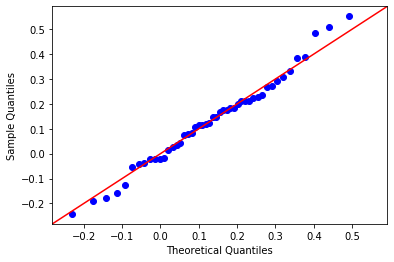

In [97]:
# Plot a QQ-Plot of the returns from 1990 - 2006 assuming a normal distribution
sm.qqplot( returns, loc = returns.mean(), scale =  returns.std() , line = '45' )

plt.show()

# The change in drilling costs looks normally distributed from 1991 - 2006 

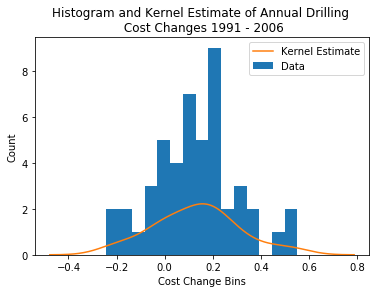

In [103]:
# Define a kernal density estimator

kde = sm.nonparametric.KDEUnivariate( returns )

### Plot a histogram of the returns with the kernel density estimator
plt.hist( returns , bins = 15 )

# Fit the kernel using Scott's method (nrd)
kde.fit( kernel = 'gau', bw = 'scott' )

# Plot the kernel function
plt.plot( kde.support, kde.density )

plt.xlabel('Cost Change Bins')

plt.ylabel('Count')

plt.title('Histogram and Kernel Estimate of Annual Drilling \n Cost Changes 1991 - 2006')

plt.legend(['Kernel Estimate', 'Data'])

plt.show()

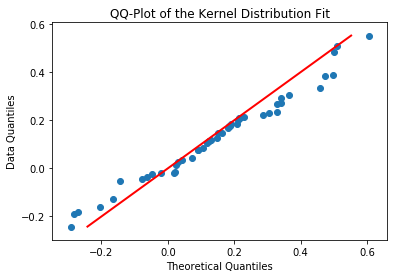

In [126]:
# Chack the fit of the kernel

# Will use the kernel resample functionality of Simulate to create theortical quantiles
sim_obj = simulate( data_array = returns, 
                   start_val = 2238.6, 
                   sims = 1000000,
                   rand_seed = 123)

# Fit the kernel
sim_obj.fit_kde()

# Sample from the kernel
qq_data = sim_obj.resample( len(returns) )

returns_df = pd.DataFrame( returns )

returns_df = returns_df.sort_values( by=0 )

qq_data.sort()

returns_df[1] = qq_data

plt.scatter( returns_df[1], returns_df[0] )

plt.plot([returns_df[0].min(), returns_df[0].max()], [returns_df[0].min(), returns_df[0].max()], color = 'r', linewidth = 2)

plt.xlabel('Theoretical Quantiles')

plt.ylabel('Data Quantiles')

plt.title('QQ-Plot of the Kernel Distribution Fit')

plt.show()

# Perform Simulations of Future Drilling Costs

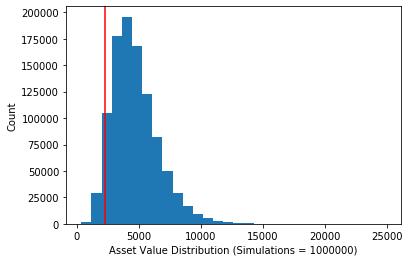

In [49]:
"""

Lets demonstrate the use of the simulate using 1,000,000 simulations forcasting the drilling costs 6 years into the 
future assuming that changes in drilling costs from year to year follow a normal distribution that has the same 
attributes as those of drilling costs from 1991 - 2006. 

"""

# Declare the class object and set its initial attributes
sim_obj = simulate( data_array = returns, 
                   start_val = 2238.6, 
                   sims = 1000000,
                   rand_seed = 123)

# Simualte the possible drilling costs 6 years into the future
norm_ints = sim_obj.do_sims( forecast_len = 6, dist = 'norm' )

# Plot the possible distribution of drilling costs in 2012
sim_obj.plot_dist()

# Looks like the price is expected to rise over the 6 year period

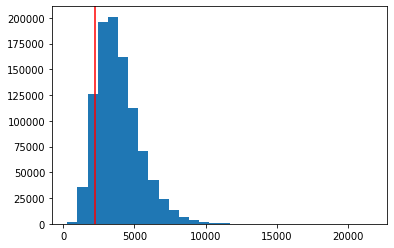

In [52]:
"""

Lets demonstrate the use of the simulate using 1,000,000 simulations forcasting the drilling costs 14 years into the 
future assuming that changes in drilling costs from year to year follow three distributions in that time. The distributions
are as follows: 
    - Normal from 2006 - 2012
    - Triangular from 2012 - 2015 with min = -0.22, avg = -0.0917, and max = -0.07
    - Triangular from 2015 - 2020 with min = 0.02, avg = 0.05, and max = 0.06

"""

dist_specs = [ None, [ -0.22, -0.0917, -0.07 ], [0.02, 0.05, 0.06] ]

chain_dists = [ 'norm', 'tri', 'tri' ]

chain_durs = [ 6, 3, 5 ]

sim_obj.chain_sims( dist_specs, chain_dists, chain_durs, plot = True )
plt.show()

# Save the forecasted values
norm_first_fores = sim_obj.forcasts[0]

# Looks like drilling costs are expected to rise from 2006 to 2020

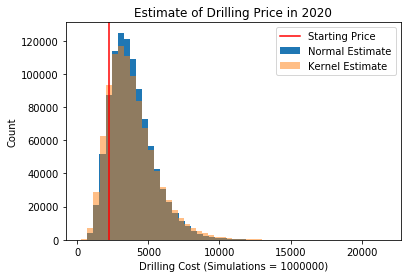

In [53]:
"""

Now lets assume that we wanted to fit a kernel instead of assuming a noraml distribution to estiamte the 
asset value. Lets change the first distribution from normal to kernel and compare the results. 

"""

dist_specs = [ None, [ -0.22, -0.0917, -0.07 ], [0.02, 0.05, 0.06] ]

chain_dists = [ 'fit_kernel', 'tri', 'tri' ]

chain_durs = [ 6, 3, 5 ]

sim_obj.chain_sims( dist_specs, chain_dists, chain_durs, plot = False )

# Save the forecasted values
kernel_first_fores = sim_obj.forcasts[0]

plt.hist( norm_first_fores, bins = 50 )

plt.hist( kernel_first_fores, bins = 50, alpha = 0.5 )

plt.axvline( sim_obj.start_val, color = 'r' )

plt.legend( ['Starting Price', 'Normal Estimate', 'Kernel Estimate'] )

plt.title( 'Estimate of Drilling Price in 2020')

plt.xlabel( 'Drilling Cost (Simulations = {0})'.format(sim_obj.sims) )

plt.ylabel( 'Count' )

plt.show()